In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
import itertools
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
pd.set_option('display.max_Columns', 100)

In [2]:
train_ = pd.read_feather('../inputs/train_feature.f')
print(train_.shape)
test_ = pd.read_feather('../inputs/test_feature.f')
print(test_.shape)

(8359, 1459)
(8360, 1454)


In [3]:
n_fold = 5

In [4]:
train_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,Rank_NA_Sales_by_Platform,Rank_EU_Sales_by_Platform,Rank_JP_Sales_by_Platform,Rank_Other_Sales_by_Platform,Rank_NA_Sales_by_Genre,Rank_EU_Sales_by_Genre,Rank_JP_Sales_by_Genre,Rank_Other_Sales_by_Genre,Rank_NA_Sales_by_Developer,Rank_EU_Sales_by_Developer,Rank_JP_Sales_by_Developer,Rank_Other_Sales_by_Developer,Rank_NA_Sales_by_Rating,Rank_EU_Sales_by_Rating,Rank_JP_Sales_by_Rating,Rank_Other_Sales_by_Rating,Rank_NA_Sales_by_Year,Rank_EU_Sales_by_Year,Rank_JP_Sales_by_Year,Rank_Other_Sales_by_Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,...,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,LEGO Batman: The Videogame,23,NaN,0,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,425,1,0,8.0,7.0,3.135494,0,31.0,31.0,24.0,29.0,12.0,12.0,10.0,12.0,1122.0,1122.0,729.0,1123.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0,1320,3370,235,77,1420,2830,2019,93.604962,61.883755,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.056565,0.643202,0.065921,0.000142,0.103320,0.000142,0.000142,0.000142,0.000142,0.130284
1,LEGO Indiana Jones: The Original Adventures,23,NaN,0,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,425,1,0,7.0,8.0,3.367296,0,31.0,31.0,24.0,29.0,12.0,12.0,10.0,12.0,1122.0,1122.0,729.0,1123.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0,1320,3370,90,77,1420,1634,2366,96.597250,58.394680,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000369,0.000369,0.286815,0.068199,0.000369,0.523832,0.037158,0.000369,0.000369,0.082150
2,LEGO Batman: The Videogame,17,NaN,0,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,425,1,0,7.0,7.0,2.397895,0,18.0,20.0,23.0,26.0,12.0,12.0,10.0,12.0,1122.0,1122.0,729.0,1123.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0,1209,3370,235,77,1420,1634,2019,29.606403,59.681720,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.056565,0.643202,0.065921,0.000142,0.103320,0.000142,0.000142,0.000142,0.000142,0.130284
3,Combat,0,NaN,0,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,467,6,0,NaN,NaN,NaN,0,17.0,11.0,1.0,11.0,12.0,12.0,10.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,2.0,3.0,133,3370,367,6623,6769,9129,8582,65.943662,62.435252,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.046832,0.000091,0.342186,0.000091,0.000091,0.342919,0.152047,0.016909,0.028151,0.070683
4,LEGO Harry Potter: Years 5-7,23,NaN,0,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,425,1,0,8.0,8.0,2.639057,0,31.0,31.0,24.0,29.0,12.0,12.0,10.0,12.0,1122.0,1122.0,729.0,1123.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,3.0,1320,3370,235,77,1420,2830,2366,96.597250,58.394680,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.056565,0.643202,0.065921,0.000142,0.103320,0.000142,0.000142,0.000142,0.000142,0.130284


In [5]:
test_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_tbd,User_Score_int,Critic_Score_int,User_Count_log,Year,Rank_NA_Sales_by_Platform,Rank_EU_Sales_by_Platform,Rank_JP_Sales_by_Platform,Rank_Other_Sales_by_Platform,Rank_NA_Sales_by_Genre,Rank_EU_Sales_by_Genre,Rank_JP_Sales_by_Genre,Rank_Other_Sales_by_Genre,Rank_NA_Sales_by_Developer,Rank_EU_Sales_by_Developer,Rank_JP_Sales_by_Developer,Rank_Other_Sales_by_Developer,Rank_NA_Sales_by_Rating,Rank_EU_Sales_by_Rating,Rank_JP_Sales_by_Rating,Rank_Other_Sales_by_Rating,Rank_NA_Sales_by_Year,Rank_EU_Sales_by_Year,Rank_JP_Sales_by_Year,Rank_Other_Sales_by_Year,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_Global_Sales_mean_by_Platform_Genre,TGE_Global_Sales_mean_by_Platform_Rating,...,WD_connect,WD_toshi,WD_alter,WD_eyes,WD_hamster,WD_shock,WD_desu,WD_kami,WD_youkai,WD_saki,WD_drum,WD_loaded,WD_snowboard,WD_roller,WD_main,WD_roku,WD_bout,WD_bound,WD_kill,WD_shiro,WD_shima,WD_kono,WD_runs,WD_mashita,WD_sign,WD_kata,WD_doko,WD_shell,WD_will,WD_limit,WD_cruis,WD_rebel,WD_builder,WD_ippo,WD_split,WD_iris,WD_start,WD_issho,WD_john,WD_michi,LDA_Publisher_0,LDA_Publisher_1,LDA_Publisher_2,LDA_Publisher_3,LDA_Publisher_4,LDA_Publisher_5,LDA_Publisher_6,LDA_Publisher_7,LDA_Publisher_8,LDA_Publisher_9
0,Hitman 2: Silent Assassin,26,NaN,0,Eidos Interactive,84.0,23.0,8.0,19.0,216,3,0,8.0,8.0,2.995732,0,20.0,16.0,10.0,14.0,12.0,12.0,10.0,12.0,916.5,1037.0,891.5,1031.5,7.0,7.0,6.0,7.0,4.0,3.0,2.0,3.0,824,3370,198,20,1563,2830,2366,28.428571,61.011474,96.410622,100.864791,99.177204,25.973684,50.600000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000168,0.000168,0.244475,0.065020,0.000168,0.443327,0.000168,0.150225,0.000168,0.096113
1,Legacy of Kain: Soul Reaver,13,NaN,0,Eidos Interactive,91.0,17.0,9.0,132.0,112,5,0,9.0,9.0,4.890349,0,26.0,26.0,30.0,24.0,12.0,12.0,10.0,12.0,833.0,975.5,764.5,921.0,6.0,6.0,7.0,6.0,4.0,3.0,2.0,3.0,1197,3370,198,25,2961,1033,760,72.632812,61.011474,50.841880,126.789762,201.134986,72.709091,230.451613,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000168,0.000168,0.244475,0.065020,0.000168,0.443327,0.000168,0.150225,0.000168,0.096113
2,Metal Gear Solid 2: Substance,26,NaN,0,Konami Digital Entertainment,87.0,28.0,8.5,39.0,469,3,0,8.0,9.0,3.688879,0,20.0,16.0,10.0,14.0,12.0,12.0,10.0,12.0,NaN,NaN,NaN,NaN,7.0,7.0,6.0,7.0,4.0,3.0,2.0,3.0,824,3370,834,12,1563,2830,760,28.428571,61.011474,96.410622,100.864791,201.134986,25.973684,50.600000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000040,0.028815,0.077305,0.334698,0.010631,0.278875,0.009451,0.024971,0.091115,0.144099
3,Silent Hill: Homecoming,25,NaN,0,Konami Digital Entertainment,70.0,54.0,6.9,180.0,134,3,0,7.0,7.0,5.198497,0,30.0,27.0,14.0,27.0,12.0,12.0,10.0,12.0,990.0,1027.0,955.5,1021.0,7.0,7.0,6.0,7.0,4.0,3.0,2.0,3.0,1262,3370,834,22,1563,1634,2019,81.399660,61.011474,96.410622,66.212871,48.703390,82.083333,150.326531,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000040,0.028815,0.077305,0.334698,0.010631,0.278875,0.009451,0.024971,0.091115,0.144099
4,Silent Hill: Homecoming,15,NaN,0,Konami Digital Entertainment,71.0,41.0,6.9,143.0,134,3,0,7.0,7.0,4.969813,0,27.0,29.0,22.0,30.0,12.0,12.0,10.0,12.0,990.0,1027.0,955.5,1021.0,7.0,7.0,6.0,7.0,4.0,3.0,2.0,3.0,1331,3370,834,22,1563,1634,2019,71.405910,61.011474,96.410622,66.212871,48.703390,92.162562,129.969925,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000040,0.028815,0.077305,0.334698,0.010631,0.278875,0.009451,0.024971,0.091115,0.144099


In [6]:
lgbm_param = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'seed' : 0,
    'learning_rate':  0.05,
#     'lambda_l1': 1.9090472958000438e-07, 
#     'lambda_l2': 1.3091776726058165e-07, 
#     'num_leaves': 64, 
#     'feature_fraction': 0.5, 
#     'bagging_fraction': 1.0, 
#     'bagging_freq': 0, 
#     'min_child_samples': 20,
    'max_depth': 6,
    'colsample_bytree': .5,
    'importance_type': 'gain'
}

In [7]:
def tuning_lgbm(X, y, group, params, verbose=100):
    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    tr_group_idx, va_group_idx = list(cv)[4]
        
    train_groups = unique_group[tr_group_idx]
    valid_groups = unique_group[va_group_idx]
    is_train = group.isin(train_groups)
    is_valid = group.isin(valid_groups)
        
    x_train, y_train = X[is_train], y[is_train]
    x_valid, y_valid = X[is_valid], y[is_valid]
    
    lgbm_train = lgbm.Dataset(x_train, y_train)
    lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
    
    best_params, tuning_history = dict(), list()
    best = lgbm.train(params,
                                  lgbm_train,
                                  valid_sets=lgbm_eval,
                                  num_boost_round=10000,
                                  early_stopping_rounds=verbose,
                                  verbose_eval=0)
    print('Best Params:', best.params)
    print('Best Iteration:', best.best_iteration)
    print('Best Score:', best.best_score)

In [8]:
# y = train_['Global_Sales'].apply(np.log1p)
# group = train_['Publisher'].copy()
# train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
# tuning_lgbm(train_, y, group, lgbm_param)

In [9]:
def train_lgbm(X, y, group, params: dict, verbose=100):

    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = list(fold.split(X)) 
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=0)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[idx_valid] = y_pred
        models.append(lgbm_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [10]:
def train_lgbm_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=0)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[is_valid] = y_pred
        models.append(lgbm_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [11]:
def train_pred(train_df, y, test_df, group):
    oof, models, score = train_lgbm_group(train_df, y, group, lgbm_param)
    
    pred_list = []
    for model in models:
            pred = model.predict(test_df, num_iteration = model.best_iteration)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [12]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [13]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

x_train (6174, 1452)
x_valid (2185, 1452)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17374
[LightGBM] [Info] Number of data points in the train set: 6174, number of used features: 417
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Start training from score 2.842922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

x_train (6856, 1452)
x_valid (1503, 1452)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17362
[LightGBM] [Info] Number of data points in the train set: 6856, number of used features: 426
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Start training from score 3.062950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

x_train (7059, 1452)
x_valid (1300, 1452)
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17486
[LightGBM] [Info] Number of data points in the train set: 7059, number of used features: 444
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Start training from score 3.042797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

17.34008618966318
17.689600436219173
19.675057096233967
16.897987165837822
17.060641941901913
CPU times: user 3min 28s, sys: 4.24 s, total: 3min 32s
Wall time: 9.38 s


In [14]:
feature_importance(models).head(50)

,name,imp_0,imp_1,imp_2,imp_3,imp_4,sum
1451,Year_of_Release,160,178,249,187,195,969
1450,User_Count,128,135,209,180,181,833
1449,Rank_NA_Sales_by_Developer,98,135,135,141,168,677
1446,TGE_Global_Sales_mean_by_Platform_Genre,61,89,201,106,119,576
1445,TGE_Global_Sales_std_by_Platform_Genre,58,67,228,82,93,528
1448,Rank_Other_Sales_by_Developer,82,76,111,134,101,504
1437,Rank_EU_Sales_by_Developer,41,107,117,89,89,443
1447,User_Count_log,68,75,131,80,78,432
1440,TGE_Global_Sales_mean_by_Platform,44,45,138,97,90,414
1442,Critic_Count,46,59,127,63,85,380


In [15]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test_)

(8360, 1)
mean= 17.732674565971227
max= 360.8547013623239


Text(0.5, 0, 'Global_Sales')

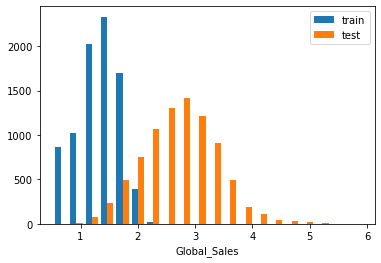

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [17]:
FILENAME = 'submission_lgbm.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission_lgbm.csv


In [18]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- lgbm = {:.4f}'.format(score))

- feat = 1452
- mean = 17.7327
- max = 360.8547
- lgbm = 1.0195


### ensumble

In [20]:
lgbm_out = pd.read_csv('../outputs/submission_lgbm.csv').rename(columns={'Global_Sales': 'lgbm'})
cat_out = pd.read_csv('../outputs/submission_cat.csv').rename(columns={'Global_Sales': 'cat'})
ensumble = pd.concat([lgbm_out, cat_out], axis=1)
ensumble['Global_Sales'] = (ensumble['lgbm']*0.7 + ensumble['cat']*0.3)
ensumble.drop(columns=['lgbm', 'cat'], inplace=True)
assert len(ensumble) == len(test_)
ensumble.to_csv('../outputs/submission.csv', index=False)

print('- mean = {:.4f}'.format(ensumble['Global_Sales'].mean()))
print('- max = {:.4f}'.format(ensumble['Global_Sales'].max()))

- mean = 17.3757
- max = 332.1963


#### 23: lgbm(0.7)+cat(0.3) Sales_Rank
- feat = 1452
- mean = 17.3757
- max = 332.1963
- lgbm = 1.0195 (lr=0.05)
- cat = 1.0367
- LB= 1.0246

#### 22: lgbm(0.7)+cat(0.3) Publisher-LDA
- feat = 1432
- mean = 26.4448
- max = 536.7920
- lgbm = 1.0752
- cat =  1.0980
- LB= 0.8911　★best★

#### 21: ensumble
- lgbm = 0.8935
- cat = 0.9055
- LB = 0.8947

#### 21: lgbm (11相当)
- feat = 1421
- mean = 25.9600
- max = 531.4130
- score = 1.0630
- LB= 0.8935　★best★

#### 19: tuning
- feat = 1421
- mean = 25.0072
- max = 589.4161
- score = 1.0913
- LB= 0.9098

#### 18: word LDA(5)
- feat = 1426
- mean = 23.9274
- max = 686.8143
- score = 1.0564
- LB= 0.9117

#### 17: nfold=7
- feat = 1421
- mean = 27.2630
- max = 547.4804
- score = 1.0484
- LB= 0.9026

#### 11: target_encでUser_Score/Critic_Score
- feat = 1420
- mean = 23.8047
- max = 489.9664
- score = 1.0795
- LB= 0.9001

#### 10: target_encのstd
- feat = 1406
- mean = 26.6392
- max = 520.2849
- score = 1.0827
- LB= 0.9013

#### 9: categoryのLDA
- feat = 1398
- mean = 23.8993
- max = 486.8888
- score = 1.0477
- LB= 0.9182

#### 8: word(1271)+TSVD(30)
- feat = 1328
- mean = 31.0632
- max = 466.2990
- score = 1.0276
- LB= 0.954

#### 7: target_enc (Global_Salesのみ, group追加)
- feat = 2476
- mean = 31.4078
- max = 579.2456
- score = 1.0236
- LB= 0.9326

#### 4-2: tuning
- feat = 2493
- mean = 34.8119
- max = 602.9193
- score = 1.0144
- LB= 0.9482

#### 4-1: hyper-param
- feat = 2493
- mean = 31.2463
- max = 569.0352
- score = 1.0288
- LB= 0.9343

### 19 tuning
#### 0
```
Best Params: {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'lambda_l1': 2.809567216186331, 'lambda_l2': 2.3907150877467426e-06, 'num_leaves': 3, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 0.7932451674615685, 'bagging_freq': 5, 'min_child_samples': 20}
Best Iteration: 365
```
#### 1
```
Best Params: {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'lambda_l1': 1.9090472958000438e-07, 'lambda_l2': 1.3091776726058165e-07, 'num_leaves': 64, 'feature_fraction': 0.5, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
Best Iteration: 52
```
#### 2
```
Best Params: {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'lambda_l1': 6.17418669463748e-05, 'lambda_l2': 4.740862185982651e-08, 'num_leaves': 31, 'feature_fraction': 0.41600000000000004, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
Best Iteration: 364
```
#### 3
```
Best Params: {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'lambda_l1': 0.008209941688332452, 'lambda_l2': 0.006693838878785605, 'num_leaves': 17, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
Best Iteration: 132
```
#### 4
```
Best Params: {'objective': 'regression', 'boosting_type': 'gbdt', 'metric': 'rmse', 'seed': 0, 'learning_rate': 0.1, 'lambda_l1': 0.041536849515201965, 'lambda_l2': 2.3716566027850097e-05, 'num_leaves': 43, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
Best Iteration: 81
```